# Lab Besos Work Flow from idf to surrogate desgin optimization


In this laboratory you will go over some of the basic work flow to create a a surrogate design optimization model from an EnergyPlus simulation. You will train a surrogate model network to find optimal design parameters.

In [233]:
#!pip install besos --user
%matplotlib inline
import time
import numpy as np
import pandas as pd


from besos import eppy_funcs as ef
from besos import sampling
from besos.evaluator import EvaluatorEP,EvaluatorGeneric
from besos.parameters import RangeParameter, FieldSelector, FilterSelector, Parameter, expand_plist, wwr, CategoryParameter, GenericSelector
from besos.problem import EPProblem, Problem
from besos import eppy_funcs as ef, sampling

import matplotlib.pyplot as plt
from seaborn import heatmap
from seaborn import pairplot
from plotly import express as px
import plotly

In [234]:

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Building presentation

In this Laboratory you will have to perform a surrogate optimization of a sample residential building unit. The considered unit is composed by a typical flat of a multi-storey building. Its internal organisation and definition is in line with suggested residential building typologies included in well-known architectural technical manuals  The considered building is composed by two units for floor, while a single unit is simulated for this chapter. The simulated spaces are considered to be at an intermediate floor with an upper floor and lower floor working at the same temperature (adiabatic). Similarly, the simulated unit is touching a specular one: confining walls are also assumed as adiabatic. Upper-floor balconies are included to consider shading effects.

![Image](image/building_lab.png)

## Load the Building 

The building is defined by the Information Data File (IDF) or using the new EnergyPlus format (IDF).

In [235]:
# Open the IDF file
building = ef.get_building('office(2).idf')
# building.view_model()

## Evaluator
## Set up the inputs and outputs of your exploration

- what properties of the building will we be changing?
- what are some of the performance metrics of the building that we want to explore?
- what external weather conditions is the building experiencing?


![Image](image/setting_up_the_evaluator.PNG)

### Load and Display Weather Data

In [236]:
#The weather conditions are specified in the EnergyPlus Weather File (EWP) file. The properties we will change in the building will be defined in the parameter space. In the objectives we will specify the what output performance metrics we wish to extract such that we can explore them later.

In [237]:
from epw import epw
meteo = epw()
    

In [238]:
epw_file='Larnaca.epw'
meteo.read(epw_file)


In [239]:
meteo.dataframe


,Year,Month,Day,Hour,Minute,Data Source and Uncertainty Flags,Dry Bulb Temperature,Dew Point Temperature,Relative Humidity,Atmospheric Station Pressure,...,Ceiling Height,Present Weather Observation,Present Weather Codes,Precipitable Water,Aerosol Optical Depth,Snow Depth,Days Since Last Snowfall,Albedo,Liquid Precipitation Depth,Liquid Precipitation Quantity
0,2005,1,1,1,60,*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?,14.2,8.8,70,101435,...,99999,9,999999999,17,0.094,0,4,0.2,0.0,99.0
1,2005,1,1,2,60,*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?,13.5,8.1,70,101435,...,99999,9,999999999,16,0.094,0,4,0.2,0.0,99.0
2,2005,1,1,3,60,*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?,12.8,8.2,73,101435,...,99999,9,999999999,16,0.094,0,4,0.2,0.0,99.0
3,2005,1,1,4,60,*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?,12.5,8.3,75,101435,...,99999,9,999999999,17,0.094,0,4,0.2,0.0,99.0
4,2005,1,1,5,60,*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?,12.2,8.0,76,101435,...,99999,9,999999999,16,0.094,0,4,0.2,0.0,99.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,2005,12,31,20,60,*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?,13.9,9.2,74,101436,...,99999,9,999999999,18,0.101,0,88,0.2,0.0,99.0
8756,2005,12,31,21,60,*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?,12.5,8.8,78,101427,...,99999,9,999999999,17,0.101,0,88,0.2,0.0,99.0
8757,2005,12,31,22,60,*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?,11.2,8.5,83,101417,...,99999,9,999999999,17,0.101,0,88,0.2,0.0,99.0
8758,2005,12,31,23,60,*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?*?,9.9,8.4,90,101408,...,99999,9,999999999,17,0.101,0,88,0.2,0.0,99.0


In [240]:
meteo.dataframe.describe()

,Year,Month,Day,Hour,Minute,Dry Bulb Temperature,Dew Point Temperature,Relative Humidity,Atmospheric Station Pressure,Extraterrestrial Horizontal Radiation,...,Ceiling Height,Present Weather Observation,Present Weather Codes,Precipitable Water,Aerosol Optical Depth,Snow Depth,Days Since Last Snowfall,Albedo,Liquid Precipitation Depth,Liquid Precipitation Quantity
count,8760.0,8760.000000,8760.000000,8760.000000,8760.0,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,...,8760.0,8760.0,8760.0,8760.000000,8760.000000,8760.0,8760.000000,8.760000e+03,8760.000000,8760.0
mean,2005.0,6.526027,15.720548,12.500000,60.0,20.339623,13.321301,66.312557,101277.640982,348.568493,...,99999.0,9.0,999999999.0,25.495662,0.174258,0.0,74.213014,2.000000e-01,0.037705,99.0
std,0.0,3.448048,8.796749,6.922582,0.0,7.095390,5.653212,16.089700,188.766190,434.018625,...,0.0,0.0,0.0,10.274516,0.060578,0.0,26.073199,2.775716e-17,0.375435,0.0
min,2005.0,1.000000,1.000000,1.000000,60.0,2.600000,-1.600000,30.000000,100507.000000,0.000000,...,99999.0,9.0,999999999.0,8.000000,0.039000,0.0,0.000000,2.000000e-01,0.000000,99.0
25%,2005.0,4.000000,8.000000,6.750000,60.0,14.800000,8.800000,53.000000,101173.000000,0.000000,...,99999.0,9.0,999999999.0,17.000000,0.126000,0.0,76.000000,2.000000e-01,0.000000,99.0
50%,2005.0,7.000000,16.000000,12.500000,60.0,20.200000,12.700000,67.000000,101315.000000,18.000000,...,99999.0,9.0,999999999.0,23.000000,0.181000,0.0,88.000000,2.000000e-01,0.000000,99.0
75%,2005.0,10.000000,23.000000,18.250000,60.0,25.800000,18.100000,80.000000,101407.000000,726.000000,...,99999.0,9.0,999999999.0,33.000000,0.218000,0.0,88.000000,2.000000e-01,0.000000,99.0
max,2005.0,12.000000,31.000000,24.000000,60.0,38.400000,27.200000,100.000000,101700.000000,1294.000000,...,99999.0,9.0,999999999.0,62.000000,0.338000,0.0,88.000000,2.000000e-01,14.200000,99.0


# Define The Problem

1. Define the parameters and your objectives you whant to change
2. Create Selectors for getting the paramters fileds in the model
3. Describe the parameter variation
4. Define your problem

In [241]:
building.idfobjects['MATERIAL']

[
Material,
    Cast Concrete (Dense)_.1,    !- Name
    Rough,                    !- Roughness
    0.1,                      !- Thickness
    1.4,                      !- Conductivity
    2100,                     !- Density
    840,                      !- Specific Heat
    0.9,                      !- Thermal Absorptance
    0.6,                      !- Solar Absorptance
    0.6;                      !- Visible Absorptance
, 
Material,
    Gypsum Plasterboard_.025,    !- Name
    Rough,                    !- Roughness
    0.025,                    !- Thickness
    0.25,                     !- Conductivity
    900,                      !- Density
    1000,                     !- Specific Heat
    0.9,                      !- Thermal Absorptance
    0.5,                      !- Solar Absorptance
    0.5;                      !- Visible Absorptance
, 
Material,
    Painted Oak_.035,         !- Name
    Rough,                    !- Roughness
    0.035,                    !- Thickness
  

In [242]:
roof_ins = FieldSelector(class_name='Material',
                         object_name='_InsulationEX_Roof_.01', # Using an existing roof insulation material
                         field_name='Thickness')
wall_ins = FieldSelector(class_name='Material',
                         object_name='_InsulationEX_.01', # Using an existing wall insulation material
                         field_name='Thickness')

In [243]:
wall_range = RangeParameter(min_val=0.1,max_val=0.5)
roof_range = RangeParameter(min_val=0.1,max_val=0.8)


We can combine this with the `Selector` above to get a `Parameter`:

In [244]:
insulation_param = [Parameter(selector=wall_ins,
                                 value_descriptor=wall_range ,
                                 name='Wall Insulation'),
                   Parameter(selector=roof_ins,
                                 value_descriptor=roof_range ,
                                 name='Roof Insulation')]
print(insulation_param)


[Parameter(selector=FieldSelector(field_name='Thickness', class_name='Material', object_name='_InsulationEX_.01'), value_descriptors=[RangeParameter(min=0.1, max=0.5)]), Parameter(selector=FieldSelector(field_name='Thickness', class_name='Material', object_name='_InsulationEX_Roof_.01'), value_descriptors=[RangeParameter(min=0.1, max=0.8)])]


/opt/conda/envs/myenv/lib/python3.9/site-packages/besos/parameters.py:424: FutureWarning:

Use value_descriptors instead of value_descriptor.



In [245]:
[window for window in building.idfobjects['FENESTRATIONSURFACE:DETAILED'] if window.Surface_Type=='Window']

[
 FenestrationSurface:Detailed,
     Block1:OfficeXSWX1f_Wall_5_0_0_0_0_0_Win,    !- Name
     Window,                   !- Surface Type
     Trp LoE (e2=e5=.1) Clr 3mm/13mm Arg - 1002,    !- Construction Name
     Block1:OfficeXSWX1f_Wall_5_0_0,    !- Building Surface Name
     ,                         !- Outside Boundary Condition Object
     AutoCalculate,            !- View Factor to Ground
     1,                        !- Frame and Divider Name
     1,                        !- Multiplier
     4,                        !- Number of Vertices
     -7.60573915,              !- Vertex 1 Xcoordinate
     -11.0151963605,           !- Vertex 1 Ycoordinate
     4.44,                     !- Vertex 1 Zcoordinate
     -2.34773915,              !- Vertex 2 Xcoordinate
     -11.0151963605,           !- Vertex 2 Ycoordinate
     4.44,                     !- Vertex 2 Zcoordinate
     -2.34773915,              !- Vertex 3 Xcoordinate
     -11.0151963605,           !- Vertex 3 Ycoordinate
     

In [246]:
windows = FieldSelector(class_name='FenestrationSurface:Detailed', 
                        object_name='*',
                        field_name='Construction Name')

In [247]:
windows.get_objects(building)

[
FenestrationSurface:Detailed,
    Block1:OfficeXSWX1f_Partition_3_0_0_0_0_0_Door,    !- Name
    Door,                     !- Surface Type
    Project internal door,    !- Construction Name
    Block1:OfficeXSWX1f_Partition_3_0_0,    !- Building Surface Name
    Block1:CorridorX1f_Partition_6_0_0_0_0_0_Door_10005,    !- Outside Boundary Condition Object
    0,                        !- View Factor to Ground
    ,                         !- Frame and Divider Name
    1,                        !- Multiplier
    4,                        !- Number of Vertices
    -4.52673915,              !- Vertex 1 Xcoordinate
    -3.0151963605,            !- Vertex 1 Ycoordinate
    3.6,                      !- Vertex 1 Zcoordinate
    -5.42673915,              !- Vertex 2 Xcoordinate
    -3.0151963605,            !- Vertex 2 Ycoordinate
    3.6,                      !- Vertex 2 Zcoordinate
    -5.42673915,              !- Vertex 3 Xcoordinate
    -3.0151963605,            !- Vertex 3 Ycoordinate
   

In [ ]:
# Updated win_arr with the correct Construction names from your IDF
win_arr = [
#    'Sgl Clr 6mm - 1001',               # Single Glazing (without shading)
#    'Sgl Clr 6mm - 2001',               # Single Glazing (with shading)
#    'Dbl LoE (e2=.1) Clr 6mm/13mm Arg - 1003', # Double Glazing (without shading)
#    'Dbl LoE (e2=.1) Clr 6mm/13mm Arg - 2003', # Double Glazing (with shading)
   'Trp LoE (e2=e5=.1) Clr 3mm/13mm Arg - 1002', # Triple Glazing (without shading)
#    'Trp LoE (e2=e5=.1) Clr 3mm/13mm Arg - 2002'  # Triple Glazing (with shading)
]

windowsTypes = CategoryParameter(win_arr)

windowsParameters = []

for fenestration in building.idfobjects["FenestrationSurface:Detailed"]:
     if fenestration.obj[2] == "Window":
        sel = FieldSelector(class_name ='FenestrationSurface:Detailed', 
                            object_name = fenestration.Name, 
                            field_name='Construction Name' )
        windowsParameters.append(Parameter(selector=sel, 
                                           value_descriptors = windowsTypes, 
                                           name='Windows types'))
        

/opt/conda/envs/myenv/lib/python3.9/site-packages/besos/parameters.py:441: UserWarning:

This parameter's descriptor is already named Windows types.The name used as an input (Windows types) will be discarded.



In [249]:
windowsParameters

[Parameter(selector=FieldSelector(field_name='Construction Name', class_name='FenestrationSurface:Detailed', object_name='Block1:OfficeXSWX1f_Wall_5_0_0_0_0_0_Win'), value_descriptors=[CategoryParameter(options=['Trp LoE (e2=e5=.1) Clr 3mm/13mm Arg - 1002'])]),
 Parameter(selector=FieldSelector(field_name='Construction Name', class_name='FenestrationSurface:Detailed', object_name='Block1:OfficeXSEX1f_Wall_5_0_0_0_0_0_Win'), value_descriptors=[CategoryParameter(options=['Trp LoE (e2=e5=.1) Clr 3mm/13mm Arg - 1002'])]),
 Parameter(selector=FieldSelector(field_name='Construction Name', class_name='FenestrationSurface:Detailed', object_name='Block1:OfficeXNWX1f_Wall_3_0_0_0_0_0_Win'), value_descriptors=[CategoryParameter(options=['Trp LoE (e2=e5=.1) Clr 3mm/13mm Arg - 1002'])]),
 Parameter(selector=FieldSelector(field_name='Construction Name', class_name='FenestrationSurface:Detailed', object_name='Block1:OfficeXNEX1f_Wall_3_0_0_0_0_0_Win'), value_descriptors=[CategoryParameter(options=['T

In [250]:
#ACH parameters selection
ventAchRange = RangeParameter(min_val = 0.0, max_val=6.0)

ventilationAchParam = []


ventACH_sel = FieldSelector(class_name = 'ZoneVentilation:DesignFlowRate', 
                    object_name = '*', 
                    field_name = 'Air Changes per Hour')
ventilationAchParam.append(Parameter(selector=ventACH_sel, 
                                     value_descriptors=ventAchRange, 
                                     name='Ventilation ACH'))


In [251]:
ventilationAchParam

[Parameter(selector=FieldSelector(field_name='Air Changes per Hour', class_name='ZoneVentilation:DesignFlowRate', object_name='*'), value_descriptors=[RangeParameter(min=0.0, max=6.0)])]

In [252]:
lights_selector = FieldSelector(class_name='Lights', object_name='*', field_name='Watts per Zone Floor Area')
lights_range = RangeParameter(min_val=8,max_val=20)

In [253]:
lights_param =     Parameter(
        lights_selector,
        value_descriptor=lights_range ,
        name="Lights Watts/Area",
    )

In [254]:
lights_param

Parameter(selector=FieldSelector(field_name='Watts per Zone Floor Area', class_name='Lights', object_name='*'), value_descriptors=[RangeParameter(min=8, max=20)])

In [255]:
[shadeControl for shadeControl in building.idfobjects["WINDOWSHADINGCONTROL"]]

[
 WindowShadingControl,
     11001,                    !- Name
     Block1:OfficeXSWX1f,      !- Zone Name
     ,                         !- Shading Control Sequence Number
     InteriorBlind,            !- Shading Type
     Trp LoE (e2=e5=.1) Clr 3mm/13mm Arg - 2002,    !- Construction with Shading Name
     OnIfHighOutdoorAirTempAndHighHorizontalSolar,    !- Shading Control Type
     _Summer_Ventilation,      !- Schedule Name
     24,                       !- Setpoint
     Yes,                      !- Shading Control Is Scheduled
     No,                       !- Glare Control Is Active
     ,                         !- Shading Device Material Name
     FixedSlatAngle,           !- Type of Slat Angle Control for Blinds
     ,                         !- Slat Angle Schedule Name
     120,                      !- Setpoint 2
     ,                         !- Daylighting Control Object Name
     Group,                    !- Multiple Surface Control Type
     Block1:OfficeXSWX1f_Wall_5_0_

In [256]:
TempShadingRange = RangeParameter(min_val = 18, max_val=30)
RadShadingRange = RangeParameter(min_val = 80, max_val=300)

setpointParams = []
shade_setpoint_sel = FieldSelector(class_name ='WindowShadingControl', 
                    object_name = '*', 
                    field_name='Setpoint' )
shade_setpoint2_sel = FieldSelector(class_name ='WindowShadingControl', 
                     object_name = '*', 
                     field_name='Setpoint 2' )
setpointParams.append(Parameter(selector=shade_setpoint_sel, value_descriptor = TempShadingRange, name='Temp Setpoint shading'))
setpointParams.append(Parameter(selector=shade_setpoint2_sel, value_descriptor = RadShadingRange, name='Rad Setpoint shading'))

In [257]:
parameters = insulation_param + windowsParameters + [lights_param] + ventilationAchParam + setpointParams

In [258]:
parameters

[Parameter(selector=FieldSelector(field_name='Thickness', class_name='Material', object_name='_InsulationEX_.01'), value_descriptors=[RangeParameter(min=0.1, max=0.5)]),
 Parameter(selector=FieldSelector(field_name='Thickness', class_name='Material', object_name='_InsulationEX_Roof_.01'), value_descriptors=[RangeParameter(min=0.1, max=0.8)]),
 Parameter(selector=FieldSelector(field_name='Construction Name', class_name='FenestrationSurface:Detailed', object_name='Block1:OfficeXSWX1f_Wall_5_0_0_0_0_0_Win'), value_descriptors=[CategoryParameter(options=['Trp LoE (e2=e5=.1) Clr 3mm/13mm Arg - 1002'])]),
 Parameter(selector=FieldSelector(field_name='Construction Name', class_name='FenestrationSurface:Detailed', object_name='Block1:OfficeXSEX1f_Wall_5_0_0_0_0_0_Win'), value_descriptors=[CategoryParameter(options=['Trp LoE (e2=e5=.1) Clr 3mm/13mm Arg - 1002'])]),
 Parameter(selector=FieldSelector(field_name='Construction Name', class_name='FenestrationSurface:Detailed', object_name='Block1:Of

In [259]:
objectives = ['Electricity:Facility','DistrictHeating:Facility','DistrictCooling:Facility'] # these get made into `MeterReader` or `VariableReader`

problem=EPProblem(parameters, objectives) # problem = parameters + objectives



In [260]:
problem.names()

['Wall Insulation',
 'Roof Insulation',
 'Windows types',
 'Lights Watts/Area',
 'Ventilation ACH',
 'Temp Setpoint shading',
 'Rad Setpoint shading',
 'Electricity:Facility',
 'DistrictHeating:Facility',
 'DistrictCooling:Facility']

## Generate the Dataset

1. Generate 10 samples with sampling strategy
2. Setup the parallel processing
3. Simulate the Samples
4. Store and recover the expensive runs

In [261]:
samples = sampling.dist_sampler(sampling.lhs, problem, num_samples=30)
samples

,Wall Insulation,Roof Insulation,Windows types,Lights Watts/Area,Ventilation ACH,Temp Setpoint shading,Rad Setpoint shading
0,0.131362,0.528866,Trp LoE (e2=e5=.1) Clr 3mm/13mm Arg - 1002,17.336656,4.641418,26.169948,146.465901
1,0.375489,0.576427,Trp LoE (e2=e5=.1) Clr 3mm/13mm Arg - 1002,11.330132,1.832637,23.333463,179.412528
2,0.192563,0.459531,Trp LoE (e2=e5=.1) Clr 3mm/13mm Arg - 1002,18.553544,4.150357,28.239878,187.813194
3,0.166432,0.552355,Trp LoE (e2=e5=.1) Clr 3mm/13mm Arg - 1002,10.583066,1.642172,28.453562,204.719636
4,0.116296,0.654793,Trp LoE (e2=e5=.1) Clr 3mm/13mm Arg - 1002,19.441612,1.586868,27.740645,203.568413
5,0.364481,0.328555,Trp LoE (e2=e5=.1) Clr 3mm/13mm Arg - 1002,15.289428,2.709711,24.143181,157.474794
6,0.153153,0.264249,Trp LoE (e2=e5=.1) Clr 3mm/13mm Arg - 1002,14.047204,2.199730,21.928957,291.605567
7,0.216223,0.796877,Trp LoE (e2=e5=.1) Clr 3mm/13mm Arg - 1002,12.451319,1.281815,19.412194,162.006347
8,0.455548,0.731296,Trp LoE (e2=e5=.1) Clr 3mm/13mm Arg - 1002,13.119745,0.551619,21.037486,107.864503
9,0.280716,0.447661,Trp LoE (e2=e5=.1) Clr 3mm/13mm Arg - 1002,16.551595,5.445887,23.801056,144.999906


In [262]:
evaluator = EvaluatorEP(problem, 
                        building, 
                        out_dir='outputdir', 
                        err_dir='outputdir',
                        epw_file=epw_file,
                        progress_bar=True)



/opt/conda/envs/myenv/lib/python3.9/site-packages/besos/evaluator.py:672: FutureWarning:

epw_file has been deprecated and will be removed in the future. Use epw instead.



Run the samples and calculate the execution time

In [263]:
t1 = time.time()
# Run Energyplus
sim_samples = evaluator.df_apply(samples,
                             keep_input=True, 
                             #keep_dirs=True, 
                             processes=1)  # flag keep_dirs to True to save all ouput
t2 = time.time()
time_of_sim = t2 - t1

Executing:   0%|          | 0/30 [00:00<?, ?row/s]

EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2025.05.25 11:39
Initializing Response Factors
Calculating CTFs for "PROJECT INTERNAL FLOOR"
Calculating CTFs for "PROJECT PARTITION"
Calculating CTFs for "PROJECT PARTITION_REV"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "WALL_LAYER"
Calculating CTFs for "ROOF_LAYER"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Computing Interior Absorption Factors
Computing Interior Diffuse Solar Absorption Factors
Initializin

Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Performing Zone Sizing Simulation
...for Sizing Period: #1 SUMMER DESIGN DAY IN UNTITLED (01-01:31-12) GIU
Warming up
Calculating Detailed Daylighting Factors, Start Date=07/15
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #2 SUMMER DESIGN DAY IN UNTITLED (01-01:31-12) LUG
Warming up
Calculating Detailed Daylighting Factors, Start Date=08/15
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #3 SUMMER DESIGN DAY IN UNTITLED (01-01:31-12) AGO
Warming up
Calculating Detailed Daylighting Factors, Start Date=09/15
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #4 SUMMER DESIGN DAY IN UNTITLED (01-01:31-12) SET
Warming up
Calculating Detailed Daylighting Factors, Start Date=01/15
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #5 WINTER DESIGN

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2025.05.25 11:41
Initializing Response Factors
Calculating CTFs for "PROJECT INTERNAL FLOOR"
Calculating CTFs for "PROJECT PARTITION"
Calculating CTFs for "PROJECT PARTITION_REV"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "WALL_LAYER"
Calculating CTFs for "WALL_LAYER"
Calculating CTFs for "ROOF_LAYER"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Computing Interior Absorption Factors
Computing Interior Diffuse So

Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #1 SUMMER DESIGN DAY IN UNTITLED (01-01:31-12) GIU
Warming up
Calculating Detailed Daylighting Factors, Start Date=07/15
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #2 SUMMER DESIGN DAY IN UNTITLED (01-01:31-12) LUG
Warming up
Calculating Detailed Daylighting Factors, Start Date=08/15
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #3 SUMMER DESIGN DAY IN UNTITLED (01-01:31-12) AGO
Warming up
Calculating Detailed Daylighting Factors, Start Date=09/15
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #4 SUMMER DESIGN DAY IN UNTITLED (01-01:31-12) SET
Warming up
Calculating Detailed Daylighting Factors, Start Date=01/15
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Pe

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2025.05.25 11:42
Initializing Response Factors
Calculating CTFs for "PROJECT INTERNAL FLOOR"
Calculating CTFs for "PROJECT PARTITION"
Calculating CTFs for "PROJECT PARTITION_REV"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "WALL_LAYER"
Calculating CTFs for "ROOF_LAYER"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Computing Interior Absorption Factors
Computing Interior Diffuse Solar Absorption Factors
Initializin

Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #1 SUMMER DESIGN DAY IN UNTITLED (01-01:31-12) GIU
Warming up
Calculating Detailed Daylighting Factors, Start Date=07/15
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #2 SUMMER DESIGN DAY IN UNTITLED (01-01:31-12) LUG
Warming up
Calculating Detailed Daylighting Factors, Start Date=08/15
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #3 SUMMER DESIGN DAY IN UNTITLED (01-01:31-12) AGO
Warming up
Calculating Detailed Daylighting Factors, Start Date=09/15
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #4 SUMMER DESIGN DAY IN UNTITLED (01-01:31-12) SET
Warming up
Calculating Detailed Daylighting Factors, Start Date=01/15
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #5 WI

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2025.05.25 11:43
Initializing Response Factors
Calculating CTFs for "PROJECT INTERNAL FLOOR"
Calculating CTFs for "PROJECT PARTITION"
Calculating CTFs for "PROJECT PARTITION_REV"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "WALL_LAYER"
Calculating CTFs for "ROOF_LAYER"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Computing Interior Absorption Factors
Computing Interior Diffuse Solar Absorption Factors
Initializin

Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Performing Zone Sizing Simulation
...for Sizing Period: #1 SUMMER DESIGN DAY IN UNTITLED (01-01:31-12) GIU
Warming up
Calculating Detailed Daylighting Factors, Start Date=07/15
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #2 SUMMER DESIGN DAY IN UNTITLED (01-01:31-12) LUG
Warming up
Calculating Detailed Daylighting Factors, Start Date=08/15
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #3 SUMMER DESIGN DAY IN UNTITLED (01-01:31-12) AGO
Warming up
Calculating Detailed Daylighting Factors, Start Date=09/15
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #4 SUMMER DESIGN DAY IN UNTITLED (01-01:31-12) SET
Warming up
Calculating Detailed Daylighting Factors, Start Date=01/15
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #5 WINTER DESIGN

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2025.05.25 11:44
Initializing Response Factors
Calculating CTFs for "PROJECT INTERNAL FLOOR"
Calculating CTFs for "PROJECT PARTITION"
Calculating CTFs for "PROJECT PARTITION_REV"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "WALL_LAYER"
Calculating CTFs for "ROOF_LAYER"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Computing Interior Absorption Factors
Computing Interior Diffuse Solar Absorption Factors
Initializin

Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Performing Zone Sizing Simulation
...for Sizing Period: #1 SUMMER DESIGN DAY IN UNTITLED (01-01:31-12) GIU
Warming up
Calculating Detailed Daylighting Factors, Start Date=07/15
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #2 SUMMER DESIGN DAY IN UNTITLED (01-01:31-12) LUG
Warming up
Calculating Detailed Daylighting Factors, Start Date=08/15
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #3 SUMMER DESIGN DAY IN UNTITLED (01-01:31-12) AGO
Warming up
Calculating Detailed Daylighting Factors, Start Date=09/15
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #4 SUMMER DESIGN DAY IN UNTITLED (01-01:31-12) SET
Warming up
Calculating Detailed Daylighting Factors, Start Date=01/15
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #5 WINTER DESIGN

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2025.05.25 11:45
Initializing Response Factors
Calculating CTFs for "PROJECT INTERNAL FLOOR"
Calculating CTFs for "PROJECT PARTITION"
Calculating CTFs for "PROJECT PARTITION_REV"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "WALL_LAYER"
Calculating CTFs for "WALL_LAYER"
Calculating CTFs for "ROOF_LAYER"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Computing Interior Absorption Factors
Computing Interior Diffuse So

Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #1 SUMMER DESIGN DAY IN UNTITLED (01-01:31-12) GIU
Warming up
Calculating Detailed Daylighting Factors, Start Date=07/15
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #2 SUMMER DESIGN DAY IN UNTITLED (01-01:31-12) LUG
Warming up
Calculating Detailed Daylighting Factors, Start Date=08/15
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #3 SUMMER DESIGN DAY IN UNTITLED (01-01:31-12) AGO
Warming up
Calculating Detailed Daylighting Factors, Start Date=09/15
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #4 SUMMER DESIGN DAY IN UNTITLED (01-01:31-12) SET
Warming up
Calculating Detailed Daylighting Factors, Start Date=01/15
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #5 WI

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2025.05.25 11:46
Initializing Response Factors
Calculating CTFs for "PROJECT INTERNAL FLOOR"
Calculating CTFs for "PROJECT PARTITION"
Calculating CTFs for "PROJECT PARTITION_REV"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "WALL_LAYER"
Calculating CTFs for "ROOF_LAYER"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Computing Interior Absorption Factors
Computing Interior Diffuse Solar Absorption Factors
Initializin

Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Performing Zone Sizing Simulation
...for Sizing Period: #1 SUMMER DESIGN DAY IN UNTITLED (01-01:31-12) GIU
Warming up
Calculating Detailed Daylighting Factors, Start Date=07/15
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #2 SUMMER DESIGN DAY IN UNTITLED (01-01:31-12) LUG
Warming up
Calculating Detailed Daylighting Factors, Start Date=08/15
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #3 SUMMER DESIGN DAY IN UNTITLED (01-01:31-12) AGO
Warming up
Calculating Detailed Daylighting Factors, Start Date=09/15
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #4 SUMMER DESIGN DAY IN UNTITLED (01-01:31-12) SET
Warming up
Calculating Detailed Daylighting Factors, Start Date=01/15
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #5 WINTER DESIGN

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2025.05.25 11:47
Initializing Response Factors
Calculating CTFs for "PROJECT INTERNAL FLOOR"
Calculating CTFs for "PROJECT PARTITION"
Calculating CTFs for "PROJECT PARTITION_REV"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "WALL_LAYER"
Calculating CTFs for "WALL_LAYER"
Calculating CTFs for "ROOF_LAYER"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Computing Interior Absorption Factors
Computing Interior Diffuse So

Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #1 SUMMER DESIGN DAY IN UNTITLED (01-01:31-12) GIU
Warming up
Calculating Detailed Daylighting Factors, Start Date=07/15
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #2 SUMMER DESIGN DAY IN UNTITLED (01-01:31-12) LUG
Warming up
Calculating Detailed Daylighting Factors, Start Date=08/15
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #3 SUMMER DESIGN DAY IN UNTITLED (01-01:31-12) AGO
Warming up
Calculating Detailed Daylighting Factors, Start Date=09/15
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #4 SUMMER DESIGN DAY IN UNTITLED (01-01:31-12) SET
Warming up
Calculating Detailed Daylighting Factors, Start Date=01/15
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #5 WI

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2025.05.25 11:48
Initializing Response Factors
Calculating CTFs for "PROJECT INTERNAL FLOOR"
Calculating CTFs for "PROJECT PARTITION"
Calculating CTFs for "PROJECT PARTITION_REV"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "WALL_LAYER"
Calculating CTFs for "WALL_LAYER"
Calculating CTFs for "WALL_LAYER"
Calculating CTFs for "ROOF_LAYER"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Computing Interior Absorption Fac

Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #1 SUMMER DESIGN DAY IN UNTITLED (01-01:31-12) GIU
Warming up
Calculating Detailed Daylighting Factors, Start Date=07/15
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #2 SUMMER DESIGN DAY IN UNTITLED (01-01:31-12) LUG
Warming up
Calculating Detailed Daylighting Factors, Start Date=08/15
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #3 SUMMER DESIGN DAY IN UNTITLED (01-01:31-12) AGO
Warming up
Calculating Detailed Daylighting Factors, Start Date=09/15
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #4 SUMMER DESIGN DAY IN UNTITLED (01-01:31-12) SET
Warming up
Calculating Detailed Daylighting Factors, Start Date=01/15
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Pe

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2025.05.25 11:49
Initializing Response Factors
Calculating CTFs for "PROJECT INTERNAL FLOOR"
Calculating CTFs for "PROJECT PARTITION"
Calculating CTFs for "PROJECT PARTITION_REV"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "WALL_LAYER"
Calculating CTFs for "WALL_LAYER"
Calculating CTFs for "ROOF_LAYER"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Computing Interior Absorption Factors
Computing Interior Diffuse So

Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #1 SUMMER DESIGN DAY IN UNTITLED (01-01:31-12) GIU
Warming up
Calculating Detailed Daylighting Factors, Start Date=07/15
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #2 SUMMER DESIGN DAY IN UNTITLED (01-01:31-12) LUG
Warming up
Calculating Detailed Daylighting Factors, Start Date=08/15
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #3 SUMMER DESIGN DAY IN UNTITLED (01-01:31-12) AGO
Warming up
Calculating Detailed Daylighting Factors, Start Date=09/15
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #4 SUMMER DESIGN DAY IN UNTITLED (01-01:31-12) SET
Warming up
Calculating Detailed Daylighting Factors, Start Date=01/15
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #5 WI

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2025.05.25 11:50
Initializing Response Factors
Calculating CTFs for "PROJECT INTERNAL FLOOR"
Calculating CTFs for "PROJECT PARTITION"
Calculating CTFs for "PROJECT PARTITION_REV"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "WALL_LAYER"
Calculating CTFs for "WALL_LAYER"
Calculating CTFs for "ROOF_LAYER"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Computing Interior Absorption Factors
Computing Interior Diffuse So

Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #1 SUMMER DESIGN DAY IN UNTITLED (01-01:31-12) GIU
Warming up
Calculating Detailed Daylighting Factors, Start Date=07/15
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #2 SUMMER DESIGN DAY IN UNTITLED (01-01:31-12) LUG
Warming up
Calculating Detailed Daylighting Factors, Start Date=08/15
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #3 SUMMER DESIGN DAY IN UNTITLED (01-01:31-12) AGO
Warming up
Calculating Detailed Daylighting Factors, Start Date=09/15
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #4 SUMMER DESIGN DAY IN UNTITLED (01-01:31-12) SET
Warming up
Calculating Detailed Daylighting Factors, Start Date=01/15
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #5 WI

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2025.05.25 11:51
Initializing Response Factors
Calculating CTFs for "PROJECT INTERNAL FLOOR"
Calculating CTFs for "PROJECT PARTITION"
Calculating CTFs for "PROJECT PARTITION_REV"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "WALL_LAYER"
Calculating CTFs for "WALL_LAYER"
Calculating CTFs for "WALL_LAYER"
Calculating CTFs for "ROOF_LAYER"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Computing Interior Absorption Fac

Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #1 SUMMER DESIGN DAY IN UNTITLED (01-01:31-12) GIU
Warming up
Calculating Detailed Daylighting Factors, Start Date=07/15
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #2 SUMMER DESIGN DAY IN UNTITLED (01-01:31-12) LUG
Warming up
Calculating Detailed Daylighting Factors, Start Date=08/15
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #3 SUMMER DESIGN DAY IN UNTITLED (01-01:31-12) AGO
Warming up
Calculating Detailed Daylighting Factors, Start Date=09/15
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #4 SUMMER DESIGN DAY IN UNTITLED (01-01:31-12) SET
Warming up
Calculating Detailed Daylighting Factors, Start Date=01/15
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Pe

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2025.05.25 11:52
Initializing Response Factors
Calculating CTFs for "PROJECT INTERNAL FLOOR"
Calculating CTFs for "PROJECT PARTITION"
Calculating CTFs for "PROJECT PARTITION_REV"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "WALL_LAYER"
Calculating CTFs for "WALL_LAYER"
Calculating CTFs for "ROOF_LAYER"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Computing Interior Absorption Factors
Computing Interior Diffuse So

Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #1 SUMMER DESIGN DAY IN UNTITLED (01-01:31-12) GIU
Warming up
Calculating Detailed Daylighting Factors, Start Date=07/15
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #2 SUMMER DESIGN DAY IN UNTITLED (01-01:31-12) LUG
Warming up
Calculating Detailed Daylighting Factors, Start Date=08/15
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #3 SUMMER DESIGN DAY IN UNTITLED (01-01:31-12) AGO
Warming up
Calculating Detailed Daylighting Factors, Start Date=09/15
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #4 SUMMER DESIGN DAY IN UNTITLED (01-01:31-12) SET
Warming up
Calculating Detailed Daylighting Factors, Start Date=01/15
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #5 WI

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2025.05.25 11:53
Initializing Response Factors
Calculating CTFs for "PROJECT INTERNAL FLOOR"
Calculating CTFs for "PROJECT PARTITION"
Calculating CTFs for "PROJECT PARTITION_REV"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "WALL_LAYER"
Calculating CTFs for "WALL_LAYER"
Calculating CTFs for "WALL_LAYER"
Calculating CTFs for "ROOF_LAYER"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Computing Interior Absorption Fac

Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #1 SUMMER DESIGN DAY IN UNTITLED (01-01:31-12) GIU
Warming up
Calculating Detailed Daylighting Factors, Start Date=07/15
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #2 SUMMER DESIGN DAY IN UNTITLED (01-01:31-12) LUG
Warming up
Calculating Detailed Daylighting Factors, Start Date=08/15
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #3 SUMMER DESIGN DAY IN UNTITLED (01-01:31-12) AGO
Warming up
Calculating Detailed Daylighting Factors, Start Date=09/15
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #4 SUMMER DESIGN DAY IN UNTITLED (01-01:31-12) SET
Warming up
Calculating Detailed Daylighting Factors, Start Date=01/15
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...fo

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2025.05.25 11:54
Initializing Response Factors
Calculating CTFs for "PROJECT INTERNAL FLOOR"
Calculating CTFs for "PROJECT PARTITION"
Calculating CTFs for "PROJECT PARTITION_REV"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "WALL_LAYER"
Calculating CTFs for "WALL_LAYER"
Calculating CTFs for "ROOF_LAYER"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Computing Interior Absorption Factors
Computing Interior Diffuse So

Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #1 SUMMER DESIGN DAY IN UNTITLED (01-01:31-12) GIU
Warming up
Calculating Detailed Daylighting Factors, Start Date=07/15
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #2 SUMMER DESIGN DAY IN UNTITLED (01-01:31-12) LUG
Warming up
Calculating Detailed Daylighting Factors, Start Date=08/15
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #3 SUMMER DESIGN DAY IN UNTITLED (01-01:31-12) AGO
Warming up
Calculating Detailed Daylighting Factors, Start Date=09/15
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #4 SUMMER DESIGN DAY IN UNTITLED (01-01:31-12) SET
Warming up
Calculating Detailed Daylighting Factors, Start Date=01/15
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Pe

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2025.05.25 11:56
Initializing Response Factors
Calculating CTFs for "PROJECT INTERNAL FLOOR"
Calculating CTFs for "PROJECT PARTITION"
Calculating CTFs for "PROJECT PARTITION_REV"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "WALL_LAYER"
Calculating CTFs for "WALL_LAYER"
Calculating CTFs for "WALL_LAYER"
Calculating CTFs for "ROOF_LAYER"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Computing Interior Absorption Fac

Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #1 SUMMER DESIGN DAY IN UNTITLED (01-01:31-12) GIU
Warming up
Calculating Detailed Daylighting Factors, Start Date=07/15
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #2 SUMMER DESIGN DAY IN UNTITLED (01-01:31-12) LUG
Warming up
Calculating Detailed Daylighting Factors, Start Date=08/15
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #3 SUMMER DESIGN DAY IN UNTITLED (01-01:31-12) AGO
Warming up
Calculating Detailed Daylighting Factors, Start Date=09/15
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #4 SUMMER DESIGN DAY IN UNTITLED (01-01:31-12) SET
Warming up
Calculating Detailed Daylighting Factors, Start Date=01/15
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #5 WI

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2025.05.25 11:57
Initializing Response Factors
Calculating CTFs for "PROJECT INTERNAL FLOOR"
Calculating CTFs for "PROJECT PARTITION"
Calculating CTFs for "PROJECT PARTITION_REV"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "WALL_LAYER"
Calculating CTFs for "ROOF_LAYER"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Computing Interior Absorption Factors
Computing Interior Diffuse Solar Absorption Factors
Initializin

Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #1 SUMMER DESIGN DAY IN UNTITLED (01-01:31-12) GIU
Warming up
Calculating Detailed Daylighting Factors, Start Date=07/15
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #2 SUMMER DESIGN DAY IN UNTITLED (01-01:31-12) LUG
Warming up
Calculating Detailed Daylighting Factors, Start Date=08/15
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #3 SUMMER DESIGN DAY IN UNTITLED (01-01:31-12) AGO
Warming up
Calculating Detailed Daylighting Factors, Start Date=09/15
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #4 SUMMER DESIGN DAY IN UNTITLED (01-01:31-12) SET
Warming up
Calculating Detailed Daylighting Factors, Start Date=01/15
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #5 WI

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2025.05.25 11:58
Initializing Response Factors
Calculating CTFs for "PROJECT INTERNAL FLOOR"
Calculating CTFs for "PROJECT PARTITION"
Calculating CTFs for "PROJECT PARTITION_REV"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "WALL_LAYER"
Calculating CTFs for "WALL_LAYER"
Calculating CTFs for "ROOF_LAYER"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Computing Interior Absorption Factors
Computing Interior Diffuse So

Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #1 SUMMER DESIGN DAY IN UNTITLED (01-01:31-12) GIU
Warming up
Calculating Detailed Daylighting Factors, Start Date=07/15
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #2 SUMMER DESIGN DAY IN UNTITLED (01-01:31-12) LUG
Warming up
Calculating Detailed Daylighting Factors, Start Date=08/15
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #3 SUMMER DESIGN DAY IN UNTITLED (01-01:31-12) AGO
Warming up
Calculating Detailed Daylighting Factors, Start Date=09/15
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #4 SUMMER DESIGN DAY IN UNTITLED (01-01:31-12) SET
Warming up
Calculating Detailed Daylighting Factors, Start Date=01/15
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #5 WI

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2025.05.25 11:59
Initializing Response Factors
Calculating CTFs for "PROJECT INTERNAL FLOOR"
Calculating CTFs for "PROJECT PARTITION"
Calculating CTFs for "PROJECT PARTITION_REV"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "WALL_LAYER"
Calculating CTFs for "WALL_LAYER"
Calculating CTFs for "ROOF_LAYER"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Computing Interior Absorption Factors
Computing Interior Diffuse So

Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #1 SUMMER DESIGN DAY IN UNTITLED (01-01:31-12) GIU
Warming up
Calculating Detailed Daylighting Factors, Start Date=07/15
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #2 SUMMER DESIGN DAY IN UNTITLED (01-01:31-12) LUG
Warming up
Calculating Detailed Daylighting Factors, Start Date=08/15
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #3 SUMMER DESIGN DAY IN UNTITLED (01-01:31-12) AGO
Warming up
Calculating Detailed Daylighting Factors, Start Date=09/15
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #4 SUMMER DESIGN DAY IN UNTITLED (01-01:31-12) SET
Warming up
Calculating Detailed Daylighting Factors, Start Date=01/15
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #5 WI

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2025.05.25 12:00
Initializing Response Factors
Calculating CTFs for "PROJECT INTERNAL FLOOR"
Calculating CTFs for "PROJECT PARTITION"
Calculating CTFs for "PROJECT PARTITION_REV"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "WALL_LAYER"
Calculating CTFs for "WALL_LAYER"
Calculating CTFs for "ROOF_LAYER"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Computing Interior Absorption Factors
Computing Interior Diffuse So

Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #1 SUMMER DESIGN DAY IN UNTITLED (01-01:31-12) GIU
Warming up
Calculating Detailed Daylighting Factors, Start Date=07/15
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #2 SUMMER DESIGN DAY IN UNTITLED (01-01:31-12) LUG
Warming up
Calculating Detailed Daylighting Factors, Start Date=08/15
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #3 SUMMER DESIGN DAY IN UNTITLED (01-01:31-12) AGO
Warming up
Calculating Detailed Daylighting Factors, Start Date=09/15
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #4 SUMMER DESIGN DAY IN UNTITLED (01-01:31-12) SET
Warming up
Calculating Detailed Daylighting Factors, Start Date=01/15
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Pe

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2025.05.25 12:01
Initializing Response Factors
Calculating CTFs for "PROJECT INTERNAL FLOOR"
Calculating CTFs for "PROJECT PARTITION"
Calculating CTFs for "PROJECT PARTITION_REV"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "WALL_LAYER"
Calculating CTFs for "WALL_LAYER"
Calculating CTFs for "WALL_LAYER"
Calculating CTFs for "ROOF_LAYER"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Computing Interior Absorption Fac

Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #1 SUMMER DESIGN DAY IN UNTITLED (01-01:31-12) GIU
Warming up
Calculating Detailed Daylighting Factors, Start Date=07/15
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #2 SUMMER DESIGN DAY IN UNTITLED (01-01:31-12) LUG
Warming up
Calculating Detailed Daylighting Factors, Start Date=08/15
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #3 SUMMER DESIGN DAY IN UNTITLED (01-01:31-12) AGO
Warming up
Calculating Detailed Daylighting Factors, Start Date=09/15
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #4 SUMMER DESIGN DAY IN UNTITLED (01-01:31-12) SET
Warming up
Calculating Detailed Daylighting Factors, Start Date=01/15
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Pe

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2025.05.25 12:02
Initializing Response Factors
Calculating CTFs for "PROJECT INTERNAL FLOOR"
Calculating CTFs for "PROJECT PARTITION"
Calculating CTFs for "PROJECT PARTITION_REV"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "WALL_LAYER"
Calculating CTFs for "WALL_LAYER"
Calculating CTFs for "WALL_LAYER"
Calculating CTFs for "ROOF_LAYER"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Computing Interior Absorption Fac

Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #1 SUMMER DESIGN DAY IN UNTITLED (01-01:31-12) GIU
Warming up
Calculating Detailed Daylighting Factors, Start Date=07/15
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #2 SUMMER DESIGN DAY IN UNTITLED (01-01:31-12) LUG
Warming up
Calculating Detailed Daylighting Factors, Start Date=08/15
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #3 SUMMER DESIGN DAY IN UNTITLED (01-01:31-12) AGO
Warming up
Calculating Detailed Daylighting Factors, Start Date=09/15
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #4 SUMMER DESIGN DAY IN UNTITLED (01-01:31-12) SET
Warming up
Calculating Detailed Daylighting Factors, Start Date=01/15
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Pe

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2025.05.25 12:03
Initializing Response Factors
Calculating CTFs for "PROJECT INTERNAL FLOOR"
Calculating CTFs for "PROJECT PARTITION"
Calculating CTFs for "PROJECT PARTITION_REV"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "WALL_LAYER"
Calculating CTFs for "WALL_LAYER"
Calculating CTFs for "WALL_LAYER"
Calculating CTFs for "ROOF_LAYER"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Computing Interior Absorption Fac

Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #1 SUMMER DESIGN DAY IN UNTITLED (01-01:31-12) GIU
Warming up
Calculating Detailed Daylighting Factors, Start Date=07/15
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #2 SUMMER DESIGN DAY IN UNTITLED (01-01:31-12) LUG
Warming up
Calculating Detailed Daylighting Factors, Start Date=08/15
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #3 SUMMER DESIGN DAY IN UNTITLED (01-01:31-12) AGO
Warming up
Calculating Detailed Daylighting Factors, Start Date=09/15
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #4 SUMMER DESIGN DAY IN UNTITLED (01-01:31-12) SET
Warming up
Calculating Detailed Daylighting Factors, Start Date=01/15
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone S

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2025.05.25 12:04
Initializing Response Factors
Calculating CTFs for "PROJECT INTERNAL FLOOR"
Calculating CTFs for "PROJECT PARTITION"
Calculating CTFs for "PROJECT PARTITION_REV"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "WALL_LAYER"
Calculating CTFs for "ROOF_LAYER"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Computing Interior Absorption Factors
Computing Interior Diffuse Solar Absorption Factors
Initializin

Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Performing Zone Sizing Simulation
...for Sizing Period: #1 SUMMER DESIGN DAY IN UNTITLED (01-01:31-12) GIU
Warming up
Calculating Detailed Daylighting Factors, Start Date=07/15
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #2 SUMMER DESIGN DAY IN UNTITLED (01-01:31-12) LUG
Warming up
Calculating Detailed Daylighting Factors, Start Date=08/15
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #3 SUMMER DESIGN DAY IN UNTITLED (01-01:31-12) AGO
Warming up
Calculating Detailed Daylighting Factors, Start Date=09/15
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #4 SUMMER DESIGN DAY IN UNTITLED (01-01:31-12) SET
Warming up
Calculating Detailed Daylighting Factors, Start Date=01/15
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #5 WINTER DESIGN

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2025.05.25 12:05
Initializing Response Factors
Calculating CTFs for "PROJECT INTERNAL FLOOR"
Calculating CTFs for "PROJECT PARTITION"
Calculating CTFs for "PROJECT PARTITION_REV"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "WALL_LAYER"
Calculating CTFs for "WALL_LAYER"
Calculating CTFs for "WALL_LAYER"
Calculating CTFs for "ROOF_LAYER"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Computing Interior Absorption Fac

Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #1 SUMMER DESIGN DAY IN UNTITLED (01-01:31-12) GIU
Warming up
Calculating Detailed Daylighting Factors, Start Date=07/15
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #2 SUMMER DESIGN DAY IN UNTITLED (01-01:31-12) LUG
Warming up
Calculating Detailed Daylighting Factors, Start Date=08/15
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #3 SUMMER DESIGN DAY IN UNTITLED (01-01:31-12) AGO
Warming up
Calculating Detailed Daylighting Factors, Start Date=09/15
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #4 SUMMER DESIGN DAY IN UNTITLED (01-01:31-12) SET
Warming up
Calculating Detailed Daylighting Factors, Start Date=01/15
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...fo

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2025.05.25 12:06
Initializing Response Factors
Calculating CTFs for "PROJECT INTERNAL FLOOR"
Calculating CTFs for "PROJECT PARTITION"
Calculating CTFs for "PROJECT PARTITION_REV"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "WALL_LAYER"
Calculating CTFs for "WALL_LAYER"
Calculating CTFs for "WALL_LAYER"
Calculating CTFs for "ROOF_LAYER"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Computing Interior Absorption Fac

Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #1 SUMMER DESIGN DAY IN UNTITLED (01-01:31-12) GIU
Warming up
Calculating Detailed Daylighting Factors, Start Date=07/15
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #2 SUMMER DESIGN DAY IN UNTITLED (01-01:31-12) LUG
Warming up
Calculating Detailed Daylighting Factors, Start Date=08/15
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #3 SUMMER DESIGN DAY IN UNTITLED (01-01:31-12) AGO
Warming up
Calculating Detailed Daylighting Factors, Start Date=09/15
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #4 SUMMER DESIGN DAY IN UNTITLED (01-01:31-12) SET
Warming up
Calculating Detailed Daylighting Factors, Start Date=01/15
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Pe

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2025.05.25 12:07
Initializing Response Factors
Calculating CTFs for "PROJECT INTERNAL FLOOR"
Calculating CTFs for "PROJECT PARTITION"
Calculating CTFs for "PROJECT PARTITION_REV"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "WALL_LAYER"
Calculating CTFs for "WALL_LAYER"
Calculating CTFs for "ROOF_LAYER"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Computing Interior Absorption Factors
Computing Interior Diffuse So

Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #1 SUMMER DESIGN DAY IN UNTITLED (01-01:31-12) GIU
Warming up
Calculating Detailed Daylighting Factors, Start Date=07/15
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #2 SUMMER DESIGN DAY IN UNTITLED (01-01:31-12) LUG
Warming up
Calculating Detailed Daylighting Factors, Start Date=08/15
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #3 SUMMER DESIGN DAY IN UNTITLED (01-01:31-12) AGO
Warming up
Calculating Detailed Daylighting Factors, Start Date=09/15
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #4 SUMMER DESIGN DAY IN UNTITLED (01-01:31-12) SET
Warming up
Calculating Detailed Daylighting Factors, Start Date=01/15
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #5 WI

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2025.05.25 12:08
Initializing Response Factors
Calculating CTFs for "PROJECT INTERNAL FLOOR"
Calculating CTFs for "PROJECT PARTITION"
Calculating CTFs for "PROJECT PARTITION_REV"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "WALL_LAYER"
Calculating CTFs for "WALL_LAYER"
Calculating CTFs for "ROOF_LAYER"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Computing Interior Absorption Factors
Computing Interior Diffuse So

Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #1 SUMMER DESIGN DAY IN UNTITLED (01-01:31-12) GIU
Warming up
Calculating Detailed Daylighting Factors, Start Date=07/15
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #2 SUMMER DESIGN DAY IN UNTITLED (01-01:31-12) LUG
Warming up
Calculating Detailed Daylighting Factors, Start Date=08/15
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #3 SUMMER DESIGN DAY IN UNTITLED (01-01:31-12) AGO
Warming up
Calculating Detailed Daylighting Factors, Start Date=09/15
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #4 SUMMER DESIGN DAY IN UNTITLED (01-01:31-12) SET
Warming up
Calculating Detailed Daylighting Factors, Start Date=01/15
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Pe

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2025.05.25 12:10
Initializing Response Factors
Calculating CTFs for "PROJECT INTERNAL FLOOR"
Calculating CTFs for "PROJECT PARTITION"
Calculating CTFs for "PROJECT PARTITION_REV"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "WALL_LAYER"
Calculating CTFs for "WALL_LAYER"
Calculating CTFs for "ROOF_LAYER"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Computing Interior Absorption Factors
Computing Interior Diffuse So

Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #1 SUMMER DESIGN DAY IN UNTITLED (01-01:31-12) GIU
Warming up
Calculating Detailed Daylighting Factors, Start Date=07/15
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #2 SUMMER DESIGN DAY IN UNTITLED (01-01:31-12) LUG
Warming up
Calculating Detailed Daylighting Factors, Start Date=08/15
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #3 SUMMER DESIGN DAY IN UNTITLED (01-01:31-12) AGO
Warming up
Calculating Detailed Daylighting Factors, Start Date=09/15
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #4 SUMMER DESIGN DAY IN UNTITLED (01-01:31-12) SET
Warming up
Calculating Detailed Daylighting Factors, Start Date=01/15
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #5 WI

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2025.05.25 12:11
Initializing Response Factors
Calculating CTFs for "PROJECT INTERNAL FLOOR"
Calculating CTFs for "PROJECT PARTITION"
Calculating CTFs for "PROJECT PARTITION_REV"
Calculating CTFs for "PROJECT INTERNAL DOOR"
Calculating CTFs for "WALL_LAYER"
Calculating CTFs for "ROOF_LAYER"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Computing Interior Absorption Factors
Computing Interior Diffuse Solar Absorption Factors
Initializin

Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #1 SUMMER DESIGN DAY IN UNTITLED (01-01:31-12) GIU
Warming up
Calculating Detailed Daylighting Factors, Start Date=07/15
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #2 SUMMER DESIGN DAY IN UNTITLED (01-01:31-12) LUG
Warming up
Calculating Detailed Daylighting Factors, Start Date=08/15
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #3 SUMMER DESIGN DAY IN UNTITLED (01-01:31-12) AGO
Warming up
Calculating Detailed Daylighting Factors, Start Date=09/15
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #4 SUMMER DESIGN DAY IN UNTITLED (01-01:31-12) SET
Warming up
Calculating Detailed Daylighting Factors, Start Date=01/15
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #5 WI

EnergyPlus Completed Successfully.


Calculate the time

In [264]:
def niceformat(seconds):
    seconds = seconds % (24 * 3600)
    hour = seconds // 3600
    seconds %= 3600
    minutes = seconds // 60
    seconds %= 60
    return hour, minutes, seconds


hours, mins, secs = niceformat(time_of_sim)

print(
    "The total running time: {:2.0f} hours {:2.0f} min {:2.0f} seconds".format(
        hours, mins, secs
    )
)
# Build a results DataFrame

The total running time:  0 hours 32 min  8 seconds


## Store the expensive calculations

Since this can quite a big run. Lets store the results such that we don't have to rerun this problem.

In [265]:

sim_samples.to_pickle("simulation_sample_10.pkl")

## Analize and describe your simulation output

In [266]:
sim_samples.describe()

,Wall Insulation,Roof Insulation,Lights Watts/Area,Ventilation ACH,Temp Setpoint shading,Rad Setpoint shading,Electricity:Facility,DistrictHeating:Facility,DistrictCooling:Facility
count,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,3.000000e+01,3.000000e+01,3.000000e+01
mean,0.301297,0.450988,14.009141,3.009182,23.999618,189.910166,1.313473e+11,3.125779e+05,1.558282e+11
std,0.117032,0.205754,3.520384,1.730291,3.517132,65.152525,1.098090e+10,1.712060e+06,1.367186e+10
min,0.112749,0.111121,8.354256,0.191443,18.149468,82.610244,1.140989e+11,0.000000e+00,1.347335e+11
25%,0.200280,0.272009,11.222387,1.600694,21.165403,135.240981,1.223173e+11,0.000000e+00,1.438612e+11
50%,0.299364,0.453596,13.876548,3.002316,23.972119,191.861230,1.324477e+11,0.000000e+00,1.547517e+11
75%,0.395659,0.621769,17.015800,4.389466,26.787843,244.731347,1.399861e+11,0.000000e+00,1.658206e+11
max,0.489336,0.796877,19.676737,5.805958,29.700327,299.124118,1.500640e+11,9.377337e+06,1.837203e+11


In [267]:
sim_samples

,Wall Insulation,Roof Insulation,Windows types,Lights Watts/Area,Ventilation ACH,Temp Setpoint shading,Rad Setpoint shading,Electricity:Facility,DistrictHeating:Facility,DistrictCooling:Facility
0,0.131362,0.528866,Trp LoE (e2=e5=.1) Clr 3mm/13mm Arg - 1002,17.336656,4.641418,26.169948,146.465901,1.398447e+11,0.000000e+00,1.674613e+11
1,0.375489,0.576427,Trp LoE (e2=e5=.1) Clr 3mm/13mm Arg - 1002,11.330132,1.832637,23.333463,179.412528,1.245596e+11,0.000000e+00,1.385988e+11
2,0.192563,0.459531,Trp LoE (e2=e5=.1) Clr 3mm/13mm Arg - 1002,18.553544,4.150357,28.239878,187.813194,1.391401e+11,0.000000e+00,1.623388e+11
3,0.166432,0.552355,Trp LoE (e2=e5=.1) Clr 3mm/13mm Arg - 1002,10.583066,1.642172,28.453562,204.719636,1.175403e+11,0.000000e+00,1.348024e+11
4,0.116296,0.654793,Trp LoE (e2=e5=.1) Clr 3mm/13mm Arg - 1002,19.441612,1.586868,27.740645,203.568413,1.422890e+11,0.000000e+00,1.467349e+11
5,0.364481,0.328555,Trp LoE (e2=e5=.1) Clr 3mm/13mm Arg - 1002,15.289428,2.709711,24.143181,157.474794,1.361064e+11,0.000000e+00,1.525043e+11
6,0.153153,0.264249,Trp LoE (e2=e5=.1) Clr 3mm/13mm Arg - 1002,14.047204,2.199730,21.928957,291.605567,1.323335e+11,0.000000e+00,1.504234e+11
7,0.216223,0.796877,Trp LoE (e2=e5=.1) Clr 3mm/13mm Arg - 1002,12.451319,1.281815,19.412194,162.006347,1.304675e+11,0.000000e+00,1.419239e+11
8,0.455548,0.731296,Trp LoE (e2=e5=.1) Clr 3mm/13mm Arg - 1002,13.119745,0.551619,21.037486,107.864503,1.325619e+11,0.000000e+00,1.488060e+11
9,0.280716,0.447661,Trp LoE (e2=e5=.1) Clr 3mm/13mm Arg - 1002,16.551595,5.445887,23.801056,144.999906,1.405804e+11,0.000000e+00,1.762311e+11


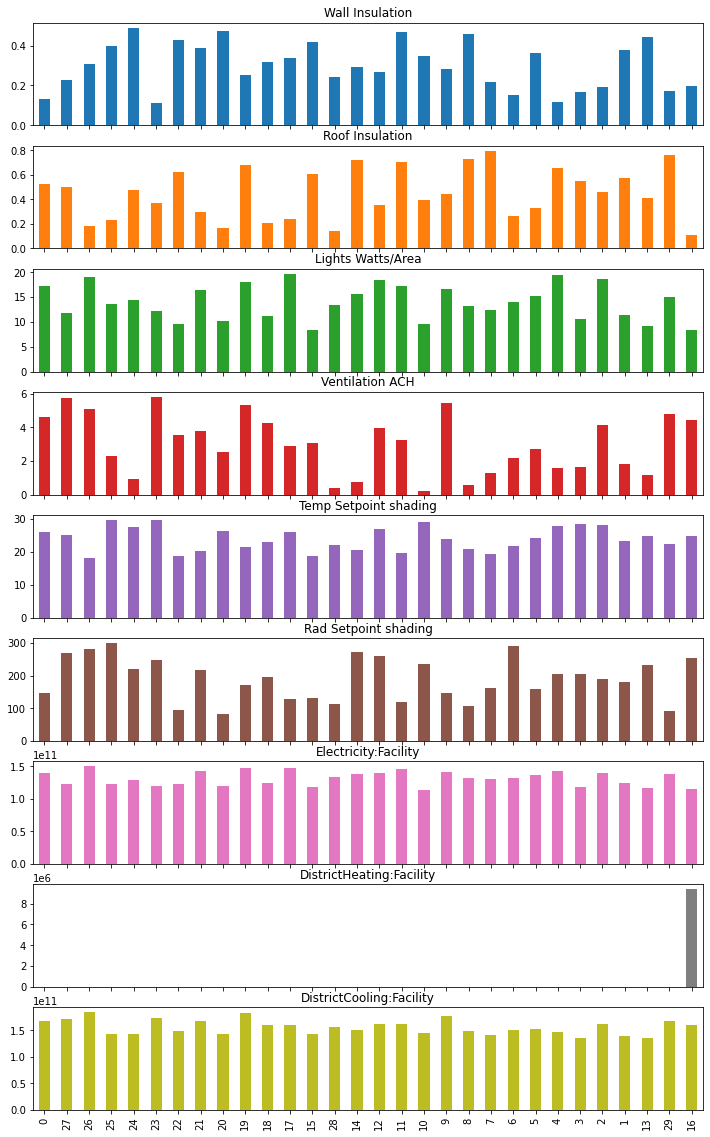

In [268]:
sim_samples = sim_samples.sort_values(by=objectives[1])
ax=sim_samples.plot.bar(subplots=True,legend=None, figsize=(12,20))

## Visualising the parametric analysis

A better way to analyse the results is by looking at scatter plots of the inputs versus the outputs.  
This enables us to visually see strong relationships of inputs and outputs.

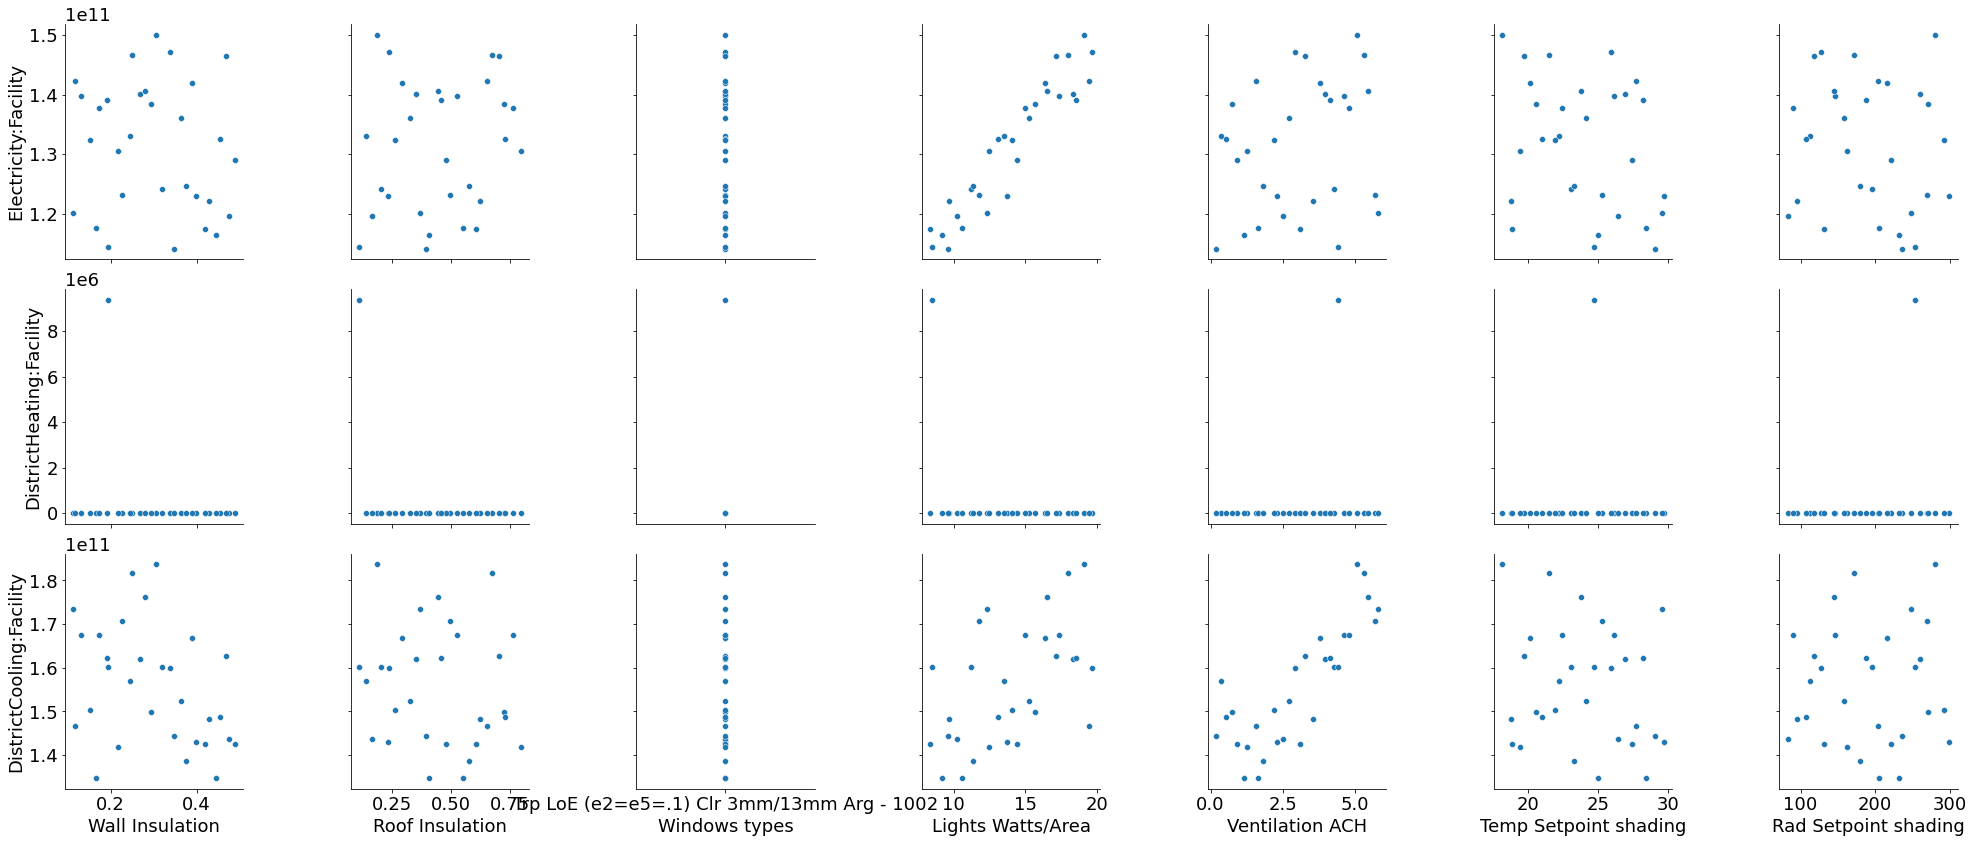

In [318]:
plt.rcParams.update({'font.size': 18})
_=pairplot(sim_samples,x_vars=samples.columns, y_vars=objectives, kind="scatter",height=4)

### Correlation heat map
Another way to analyse the impact of the inputs on the outputs is by analysing the correlation.  
A common metric is the Pearsson correlation coefficient:

$ r = \frac{N\sum{XY}-(\sum{X}\sum{Y})}{\sqrt{ [N\sum{x^2}-(\sum{x})^2 ][N\sum{y^2}-(\sum{y})^2 }]} $

where N is the number of samples. $X$ is the vector of observation of variable 1 (e.g. wall conductivity) and $Y$ is the vetor of observations of variable 2 (e.g. electricity consumption).  
The closer $r$ is to one the stronger the correlation, and similarly for negative one and negative correleation.

To visualize the correlation coefficients of all inputs and outputs, we can plot a heatmap:

In [270]:
corr=sim_samples.corr()
corr

,Wall Insulation,Roof Insulation,Lights Watts/Area,Ventilation ACH,Temp Setpoint shading,Rad Setpoint shading,Electricity:Facility,DistrictHeating:Facility,DistrictCooling:Facility
Wall Insulation,1.000000,-0.035675,-0.248501,-0.346770,-0.259874,-0.258333,-0.141336,-0.171600,-0.357371
Roof Insulation,-0.035675,1.000000,0.075408,-0.120949,-0.288767,-0.317128,0.165193,-0.311977,-0.136570
Lights Watts/Area,-0.248501,0.075408,1.000000,0.248115,-0.003143,0.027659,0.944391,-0.297975,0.545060
Ventilation ACH,-0.346770,-0.120949,0.248115,1.000000,-0.045947,0.046378,0.246981,0.154794,0.815121
Temp Setpoint shading,-0.259874,-0.288767,-0.003143,-0.045947,1.000000,0.300937,-0.311129,0.039618,-0.176943
Rad Setpoint shading,-0.258333,-0.317128,0.027659,0.046378,0.300937,1.000000,-0.133975,0.184438,0.044673
Electricity:Facility,-0.141336,0.165193,0.944391,0.246981,-0.311129,-0.133975,1.000000,-0.292247,0.584668
DistrictHeating:Facility,-0.171600,-0.311977,-0.297975,0.154794,0.039618,0.184438,-0.292247,1.000000,0.059156
DistrictCooling:Facility,-0.357371,-0.136570,0.545060,0.815121,-0.176943,0.044673,0.584668,0.059156,1.000000


In [271]:
corr.drop(objectives, axis = 1, inplace = True)
corr.drop(['Roof Insulation','Wall Insulation', 'Lights Watts/Area','Ventilation ACH','Temp Setpoint shading', 'Rad Setpoint shading'], axis = 0 ,inplace = True)
corr

,Wall Insulation,Roof Insulation,Lights Watts/Area,Ventilation ACH,Temp Setpoint shading,Rad Setpoint shading
Electricity:Facility,-0.141336,0.165193,0.944391,0.246981,-0.311129,-0.133975
DistrictHeating:Facility,-0.171600,-0.311977,-0.297975,0.154794,0.039618,0.184438
DistrictCooling:Facility,-0.357371,-0.136570,0.545060,0.815121,-0.176943,0.044673


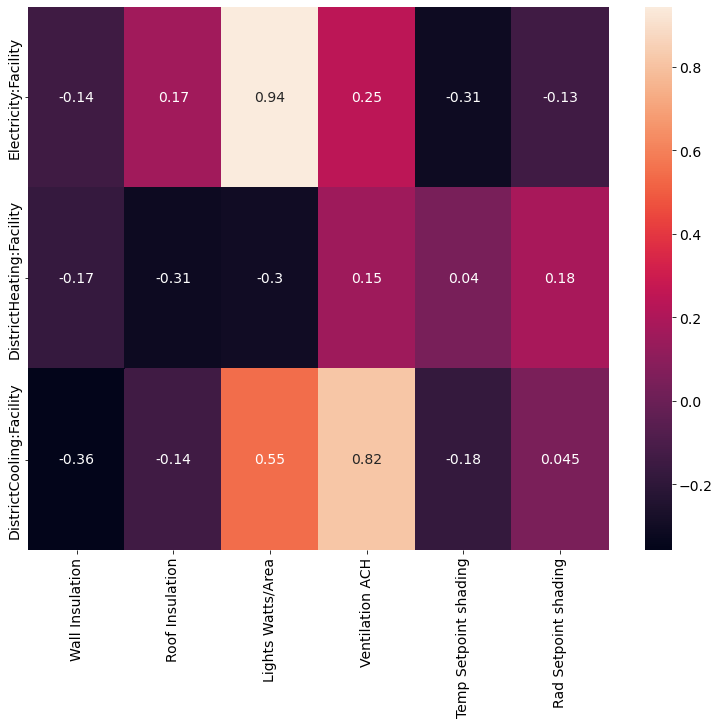

In [272]:
plt.rcParams.update({'font.size': 14})
plt.figure(figsize = (13,10))
_ = heatmap(corr,annot=True)


# Setup the dataset for the Surrogate Model

In [273]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, RationalQuadratic
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
import warnings

In [274]:
features = list(samples.columns)
print(features)
print(objectives)

['Wall Insulation', 'Roof Insulation', 'Windows types', 'Lights Watts/Area', 'Ventilation ACH', 'Temp Setpoint shading', 'Rad Setpoint shading']
['Electricity:Facility', 'DistrictHeating:Facility', 'DistrictCooling:Facility']


In [275]:
#remove inputs
outputs = sim_samples.drop(features, axis=1)
#outputs

In [276]:
#remove outputs and windows types shading
samples = sim_samples.drop(objectives, axis=1)
#samples

In [277]:
for i,win in enumerate(win_arr):
    samples['Windows types'] = samples['Windows types'].replace(win,i+1)

In [278]:
samples

,Wall Insulation,Roof Insulation,Windows types,Lights Watts/Area,Ventilation ACH,Temp Setpoint shading,Rad Setpoint shading
0,0.131362,0.528866,1,17.336656,4.641418,26.169948,146.465901
27,0.226924,0.498271,1,11.729187,5.718293,25.292117,268.708420
26,0.305568,0.186134,1,19.100387,5.065558,18.149468,280.162081
25,0.397798,0.233471,1,13.705892,2.319221,29.700327,299.124118
24,0.489336,0.478547,1,14.441279,0.914858,27.454565,220.986393
23,0.112749,0.372448,1,12.300209,5.805958,29.596164,247.873016
22,0.428095,0.626160,1,9.645147,3.555948,18.774278,95.857013
21,0.389241,0.295292,1,16.396774,3.780633,20.147321,215.934657
20,0.474540,0.167874,1,10.196681,2.529938,26.429057,82.610244
19,0.250614,0.677070,1,17.957619,5.310767,21.549153,171.988230


## Train-test split

Next we split the data into a training set (80%) and a testing set (20%).

In [279]:
train_in, test_in, train_out, test_out = train_test_split(
    samples, outputs, test_size=0.2
)

## Normalization of inputs

To ensure an equal weighting of inputs and outputs in the backpropagation algorithm fitting the neural network, we have to normalize the input values.
For example window-to-wall ratio is in the range of 0 to 1 while the $W/$m^2$ are in a range of 10 to 15.
Different options for normalization exist.
Here we bring all features (input variables) to have zero mean and a standarddeviation of 1.
Note that we fit the normalizer on training data only.

In [280]:
scaler = StandardScaler()
train_in_scale = scaler.fit_transform(X=train_in)
test_in_scale = scaler.fit_transform(X=test_in)

scaler_out = StandardScaler()
train_out_scale = scaler_out.fit_transform(X=train_out)
test_out_scale = scaler_out.fit_transform(X=test_out)

# Gaussian Process


## Hyper-parameters

Before fitting the GP model we define the set of hyperparameters we want to optimize.
Here we use \textit{3} folds in the k-fold cross validation scheme.
We select a set of Kernel functions, which must fit the characteristics of a problem - details and examples may be found in the [Kernel cookbook](https://www.cs.toronto.edu/~duvenaud/cookbook/).
Note that the parameters of the Kernel itself are [optimized during each model fitting run](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessRegressor.html).

In [281]:
hyperparameters = {
    "kernel": [
        None,
        1.0 * RBF(length_scale=1.0, length_scale_bounds=(1e-1, 10.0)),
        1.0 * RationalQuadratic(length_scale=1.0, alpha=0.5),
        # ConstantKernel(0.1, (0.01, 10.0))*(DotProduct(sigma_0=1.0, sigma_0_bounds=(0.1, 10.0))**2),
        1.0 * Matern(length_scale=1.0, length_scale_bounds=(1e-1, 10.0)),
    ]
}

folds = 3

## Model fitting

Here we fit the model using these hyperparameters.

In [282]:
gp = GaussianProcessRegressor(normalize_y=True)

clf = GridSearchCV(gp, hyperparameters, cv=folds)

clf.fit(train_in_scale, train_out_scale)

best_gp = clf.best_estimator_ 

/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning:

The optimal value found for dimension 0 of parameter k2__alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.

/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning:

The optimal value found for dimension 0 of parameter k2__alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.



In [283]:
prediction_gp = scaler_out.inverse_transform(best_gp.predict(test_in_scale))

# Neural Network

## Hyper-parameters

Before we start fitting the NN model we define the set of hyperparameters we want to analyse in our cross-validation to optimize the model.
Here, we select the number of layers of the network as well as the regularization parameter alpha as parameter value.
A larger number of layers and a lower value of the regularizer lead to higher variance of the network.
This may lead to overfitting.
The best selection may be found using an optimizer like Bayesian Optimization.
In this example we use a simple grid search.

In [284]:
hyperparameters = {
    "hidden_layer_sizes": (
        (len(parameters) * 16,),
        (len(parameters) * 16, len(parameters) * 16),
    ),
    "alpha": [1, 10, 10 ** 3],
}

neural_net = MLPRegressor(max_iter=1000, early_stopping=False)
folds = 3

## Model fitting

Here, we use the NN model from ScikitLearn.


In [285]:
clf = GridSearchCV(neural_net, hyperparameters, cv=folds)
clf.fit(train_in_scale, train_out_scale)

nn_model = clf.best_estimator_

In [286]:
prediction_nn = scaler_out.inverse_transform(nn_model.predict(test_in_scale))

In [287]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [288]:
def build_model():
    model = keras.Sequential(
        [
            layers.Input(shape=(train_in_scale.shape[1], )),
            layers.Dense(32, activation='relu'),
            layers.Dense(64, activation='relu'),
            layers.Dense(32, activation='relu'),
            layers.Dense(3),
        ]
    )

    optimizer = tf.keras.optimizers.Adam(0.001)

    model.compile(loss="mse", optimizer=optimizer, metrics=["mae", "mse"])
    return model

tf_model = build_model()

tf_model.summary()

EPOCHS = 1000

history = tf_model.fit(
    train_in_scale,
    train_out_scale,
    epochs=EPOCHS,
    validation_split=0.2,
    verbose=0,
)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 32)                256       
                                                                 
 dense_9 (Dense)             (None, 64)                2112      
                                                                 
 dense_10 (Dense)            (None, 32)                2080      
                                                                 
 dense_11 (Dense)            (None, 3)                 99        
                                                                 
Total params: 4,547
Trainable params: 4,547
Non-trainable params: 0
_________________________________________________________________


In [289]:
prediction_tf = scaler_out.inverse_transform(tf_model.predict(test_in_scale))

In [290]:
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from math import sqrt


In [291]:
mean_squared_error(prediction_gp,test_out.values,multioutput='raw_values',squared=False)/test_out.mean()*100

Electricity:Facility        4.827804
DistrictHeating:Facility         inf
DistrictCooling:Facility    4.355079
dtype: float64

In [292]:
mean_squared_error(prediction_nn,test_out.values,multioutput='raw_values')/test_out.mean()*100

Electricity:Facility        5.877437e+10
DistrictHeating:Facility             inf
DistrictCooling:Facility    8.946310e+10
dtype: float64

In [293]:
mean_squared_error(prediction_tf,test_out.values,multioutput='raw_values',squared=False)/test_out.mean()*100

Electricity:Facility        3.529531
DistrictHeating:Facility         inf
DistrictCooling:Facility    3.935914
dtype: float64

Try with more samples 20 and 40

In [294]:
#You can load the data from the files in the sim_samples_folder
# 20 samples generation took: 5 min 18 seconds
# 40 samples generation took: 19 min  7 seconds


## Surrogate Modelling Evaluator object
We can wrap the fitted model in a BESOS `Evaluator`.

In [319]:
#Selection of windows parameters
win_arr=[1,2,3]
windowsTypes = CategoryParameter(win_arr)

windowsParameters = []

for fenestration in building.idfobjects["FenestrationSurface:Detailed"]:
     if fenestration.obj[2] == "Window":
        sel = FieldSelector(class_name ='FenestrationSurface:Detailed', object_name = fenestration.Name, field_name='Construction Name' )
        windowsParameters.append(Parameter(selector=sel, value_descriptors = windowsTypes, name='Windows types'))

/opt/conda/envs/myenv/lib/python3.9/site-packages/besos/parameters.py:441: UserWarning:

This parameter's descriptor is already named Windows types.The name used as an input (Windows types) will be discarded.



In [320]:
parameters = insulation_param + windowsParameters + [lights_param]  + ventilationAchParam + setpointParams

In [321]:
#objectives and problem definition
objectives = ['Electricity:Facility','DistrictHeating:Facility','DistrictCooling:Facility']

problem=Problem(parameters, objectives)


In [322]:
#definition of the evaluation function
def evaluation_func(ind, scaler=scaler):
    ind = scaler.transform(X=[ind])
    return (scaler_out.inverse_transform(nn_model.predict(ind))[0]).tolist()

evaluator = EvaluatorGeneric(evaluation_func, problem)


In [323]:
srinputs = sampling.dist_sampler(sampling.lhs, problem, 500)
for i,win in enumerate(win_arr):
    srinputs['Windows types'] = srinputs['Windows types'].replace(win,i+1)
srinputs

,Wall Insulation,Roof Insulation,Windows types,Lights Watts/Area,Ventilation ACH,Temp Setpoint shading,Rad Setpoint shading
0,0.495010,0.373016,2,12.005324,0.870311,29.881127,93.346235
1,0.291755,0.625360,2,9.363409,4.536471,19.994322,124.911695
2,0.307444,0.327101,2,13.146775,0.227393,24.696059,220.089753
3,0.405450,0.730014,3,13.226445,0.836260,21.293927,188.672486
4,0.303391,0.608798,2,11.198011,2.522151,26.878717,267.386829
...,...,...,...,...,...,...,...
495,0.271260,0.142361,3,16.979056,1.502428,21.730176,201.289794
496,0.321682,0.281802,2,17.053193,2.462536,25.412037,298.440438
497,0.252569,0.705599,1,8.511209,3.174644,28.924341,155.874415
498,0.210672,0.273252,1,16.441344,0.990111,26.982699,81.224889


In [324]:
sroutputs = evaluator.df_apply(srinputs)
srresults = srinputs.join(sroutputs)
srresults.head()

Executing:   0%|          | 0/500 [00:00<?, ?row/s]

/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but StandardScaler

,Wall Insulation,Roof Insulation,Windows types,Lights Watts/Area,Ventilation ACH,Temp Setpoint shading,Rad Setpoint shading,Electricity:Facility,DistrictHeating:Facility,DistrictCooling:Facility
0,0.495010,0.373016,2,12.005324,0.870311,29.881127,93.346235,1.347491e+11,0.000010,1.555939e+11
1,0.291755,0.625360,2,9.363409,4.536471,19.994322,124.911695,1.347491e+11,0.000009,1.555940e+11
2,0.307444,0.327101,2,13.146775,0.227393,24.696059,220.089753,1.347491e+11,0.000010,1.555940e+11
3,0.405450,0.730014,3,13.226445,0.836260,21.293927,188.672486,1.347491e+11,0.000008,1.555940e+11
4,0.303391,0.608798,2,11.198011,2.522151,26.878717,267.386829,1.347491e+11,0.000010,1.555940e+11


## Exploration

In [301]:
import plotly
plotly.offline.init_notebook_mode(connected=True)

In [302]:
import plotly.express as px
fig = px.parallel_coordinates(srresults,color="Electricity:Facility", dimensions=features+objectives,
                             color_continuous_scale=px.colors.diverging.Tealrose)
fig.show()

# Perform Building Optimization 

Using the best surrogate perfomr an otimization process, selct optimal values and save a new idf with the selected values. Evalute the goodnes of the surrogate simuation with EnergyPlus.

In [303]:
from besos.optimizer import NSGAII

In [304]:
#running NSGA-II optimizator 
results = NSGAII(evaluator, evaluations=5000, population_size=10000)



/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but StandardScaler

In [305]:
optres = results.loc[results["pareto-optimal"] == True, :]  # Get only the optimal results

Text(0.5, 0, 'Electricity demand')

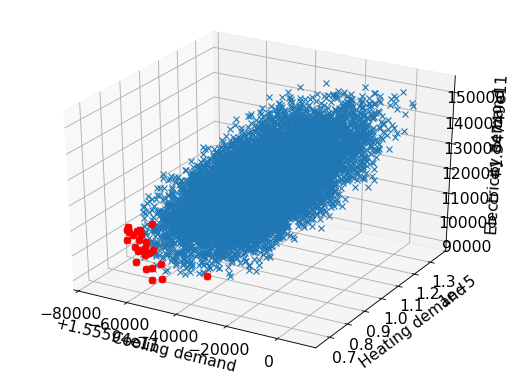

In [306]:
#plotting results
plt.figure(figsize=(8, 6), dpi=80)
ax = plt.axes(projection='3d')



df = pd.DataFrame(optres, columns=features + objectives)

ax.plot3D(results["DistrictCooling:Facility"], results["DistrictHeating:Facility"], results["Electricity:Facility"], "x")  # Plot all results in the background as blue crosses
ax.plot3D(optres["DistrictCooling:Facility"], optres["DistrictHeating:Facility"], optres["Electricity:Facility"], "ro")  # Plot optimal results in red

ax.set_xlabel("Cooling demand")
ax.set_ylabel("Heating demand")
ax.set_zlabel("Electricity demand")



In [307]:
optres

,Wall Insulation,Roof Insulation,Windows types,Lights Watts/Area,Ventilation ACH,Temp Setpoint shading,Rad Setpoint shading,Electricity:Facility,DistrictHeating:Facility,DistrictCooling:Facility,violation,pareto-optimal
176,0.448652,0.784700,3,8.654638,0.830248,27.132378,114.249162,1.347491e+11,0.000007,1.555939e+11,0,True
273,0.219313,0.748795,3,10.150822,0.168462,29.867176,102.945929,1.347491e+11,0.000007,1.555939e+11,0,True
866,0.398166,0.797482,3,18.534996,0.464703,25.858259,124.149935,1.347491e+11,0.000007,1.555939e+11,0,True
1302,0.478753,0.792943,1,10.959755,0.882149,23.840181,112.717373,1.347491e+11,0.000008,1.555939e+11,0,True
1967,0.173614,0.746667,1,9.851785,0.089980,29.740375,229.633913,1.347491e+11,0.000009,1.555940e+11,0,True
2161,0.489461,0.784379,1,14.104649,0.939082,27.734085,118.044451,1.347491e+11,0.000008,1.555939e+11,0,True
3040,0.383016,0.667132,2,11.382305,0.427577,27.650656,112.256101,1.347491e+11,0.000008,1.555939e+11,0,True
3652,0.485021,0.444773,1,9.507564,0.062888,26.840939,88.407082,1.347491e+11,0.000010,1.555939e+11,0,True
4036,0.391295,0.750599,3,17.315495,0.005245,23.511599,108.113857,1.347491e+11,0.000007,1.555939e+11,0,True
4457,0.404669,0.781976,3,10.231965,0.010688,23.019562,138.455857,1.347491e+11,0.000007,1.555939e+11,0,True


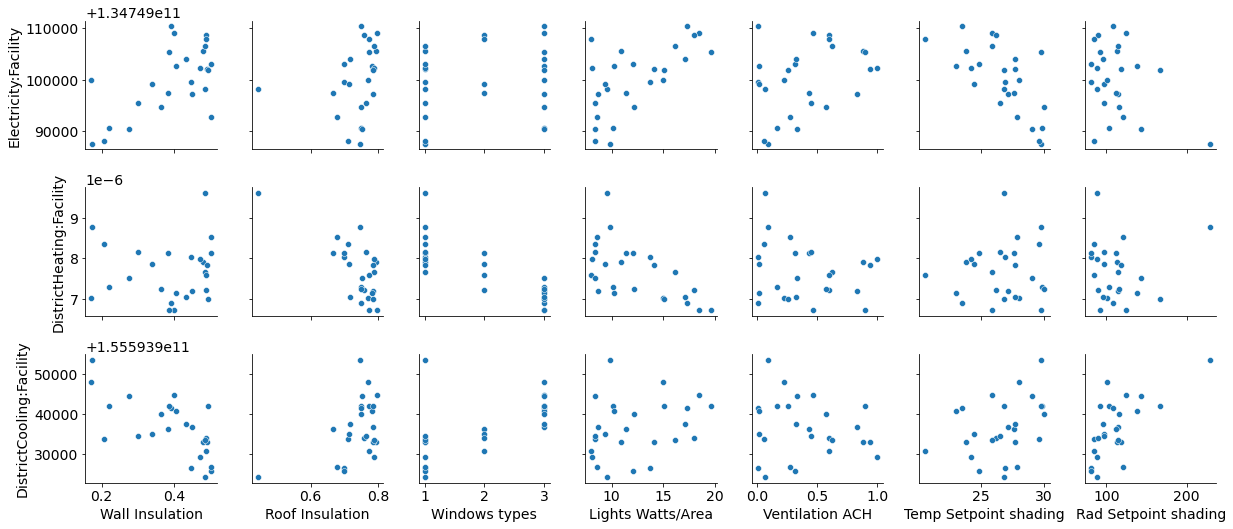

In [308]:
_=pairplot(optres,x_vars=samples.columns, y_vars=objectives, kind="scatter")

In [309]:
corr=optres.corr()

In [310]:
unuseful = ['violation','pareto-optimal']


In [311]:
corr.drop(objectives + unuseful, axis = 1, inplace = True)
corr.drop(features + unuseful, axis = 0 ,inplace = True)
corr

,Wall Insulation,Roof Insulation,Windows types,Lights Watts/Area,Ventilation ACH,Temp Setpoint shading,Rad Setpoint shading
Electricity:Facility,0.625769,0.257818,0.165596,0.636776,0.336294,-0.671869,-0.337594
DistrictHeating:Facility,0.020975,-0.702135,-0.814181,-0.603687,-0.219194,0.063411,0.029682
DistrictCooling:Facility,-0.671221,0.459461,0.627718,0.267381,-0.145523,0.363204,0.661189


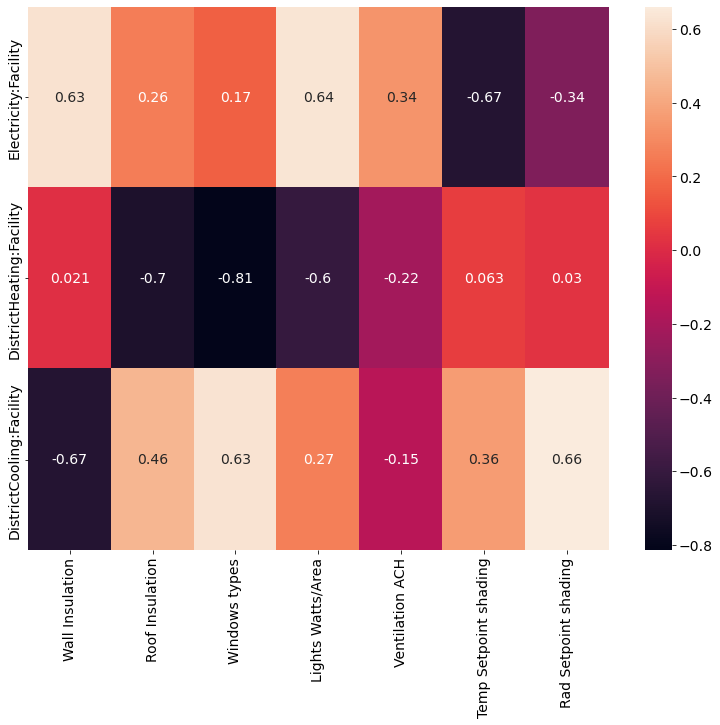

In [312]:
plt.figure(figsize = (13,10))
_ = heatmap(corr,annot=True)

In [313]:
df['Total'] = df['Electricity:Facility'] + df['DistrictHeating:Facility'] + df['DistrictCooling:Facility']
df['Dist'] = df.apply(lambda row : np.sqrt(pow(row["DistrictCooling:Facility"],2) + pow(row["DistrictHeating:Facility"],2) + pow(row["Electricity:Facility"],2)),axis=1)

df[df.Dist == df.Dist.min()]


,Wall Insulation,Roof Insulation,Windows types,Lights Watts/Area,Ventilation ACH,Temp Setpoint shading,Rad Setpoint shading,Electricity:Facility,DistrictHeating:Facility,DistrictCooling:Facility,Total,Dist
9257,0.499768,0.679734,1,8.601171,0.272749,27.840928,120.402001,1.347491e+11,0.000009,1.555939e+11,2.903430e+11,2.058319e+11


In [314]:
optimal_params=df.loc[df.Dist == df.Dist.min(),features].to_dict('records')[0]
optimal_params

{'Wall Insulation': 0.499768179682052,
 'Roof Insulation': 0.6797341483583358,
 'Windows types': 1,
 'Lights Watts/Area': 8.60117073178262,
 'Ventilation ACH': 0.2727493216620698,
 'Temp Setpoint shading': 27.840928200385747,
 'Rad Setpoint shading': 120.40200113786562}

In [315]:
lights_selector.set(building,optimal_params['Lights Watts/Area'])
roof_ins.set(building,optimal_params['Roof Insulation'])
wall_ins.set(building,optimal_params['Wall Insulation'])
shade_setpoint_sel.set(building,optimal_params['Temp Setpoint shading'])
shade_setpoint2_sel.set(building,optimal_params['Rad Setpoint shading'])
ventACH_sel.set(building,optimal_params['Ventilation ACH'])
#selection of windows parameters
win_type = 'triple_glazing'
for fenestration in building.idfobjects["FenestrationSurface:Detailed"]:
     if fenestration.obj[2] == "Window":
        win_sel = FieldSelector(class_name ='FenestrationSurface:Detailed', 
                            object_name = fenestration.Name, 
                            field_name='Construction Name' )
        win_sel.set(building,win_type)

In [316]:
building.saveas('lab_optimal.idf')

In [ ]:
building.idfobjects['MATERIAL']
	win_arr = ['single_glazing','double_glazing','triple_glazing']


[
Material,
    Cast Concrete (Dense)_.1,    !- Name
    Rough,                    !- Roughness
    0.1,                      !- Thickness
    1.4,                      !- Conductivity
    2100,                     !- Density
    840,                      !- Specific Heat
    0.9,                      !- Thermal Absorptance
    0.6,                      !- Solar Absorptance
    0.6;                      !- Visible Absorptance
, 
Material,
    Gypsum Plasterboard_.025,    !- Name
    Rough,                    !- Roughness
    0.025,                    !- Thickness
    0.25,                     !- Conductivity
    900,                      !- Density
    1000,                     !- Specific Heat
    0.9,                      !- Thermal Absorptance
    0.5,                      !- Solar Absorptance
    0.5;                      !- Visible Absorptance
, 
Material,
    Painted Oak_.035,         !- Name
    Rough,                    !- Roughness
    0.035,                    !- Thickness
  